## Chapter 8: Linear regression

# 8.3  Least absolute deviations linear regression

In this Section we talk about a slight twist on the derivation of the Least Squares cost function that leads to an alternative cost for linear regression called *Least Absolute Deviations*.  This alternative cost function is much robust to outliers in a dataset than the original Least Squares.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib

# demos for this notebook
regress_plotter = superlearn.lin_regression_demos
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer();

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

## 8.3.1  The susceptibility of the Least Squares cost to outliers

One downside of using the squared error in the Least Squares cost - as a measure that we then minimize to recover optimal linear regression parameters -  is that *squaring the error increases the importance of larger errors*.  In particular squaring errors of length greater than $1$ makes these values considerably larger.  This forces weights learned via the Least Squares cost to produce a linear fit that is especially focused on trying to minimize these large errors - often due to *outliers* in a dataset.   In other words, the Least Squares cost produces linear models that *tend to overfit to outliers in a dataset*.  

We illustrate this fact via a simple dataset in the following example.

#### <span style="color:#a50e3e;">Example 1: </span>  Least Squares overfits to outliers

In this example we use the dataset plotted below - which can largely be represented by a proper linear model with the exception of a single large outlier - to show how the Least Squares cost function for linear regression tends to create linear models that *overfit* to outliers.

<IPython.core.display.Javascript object>


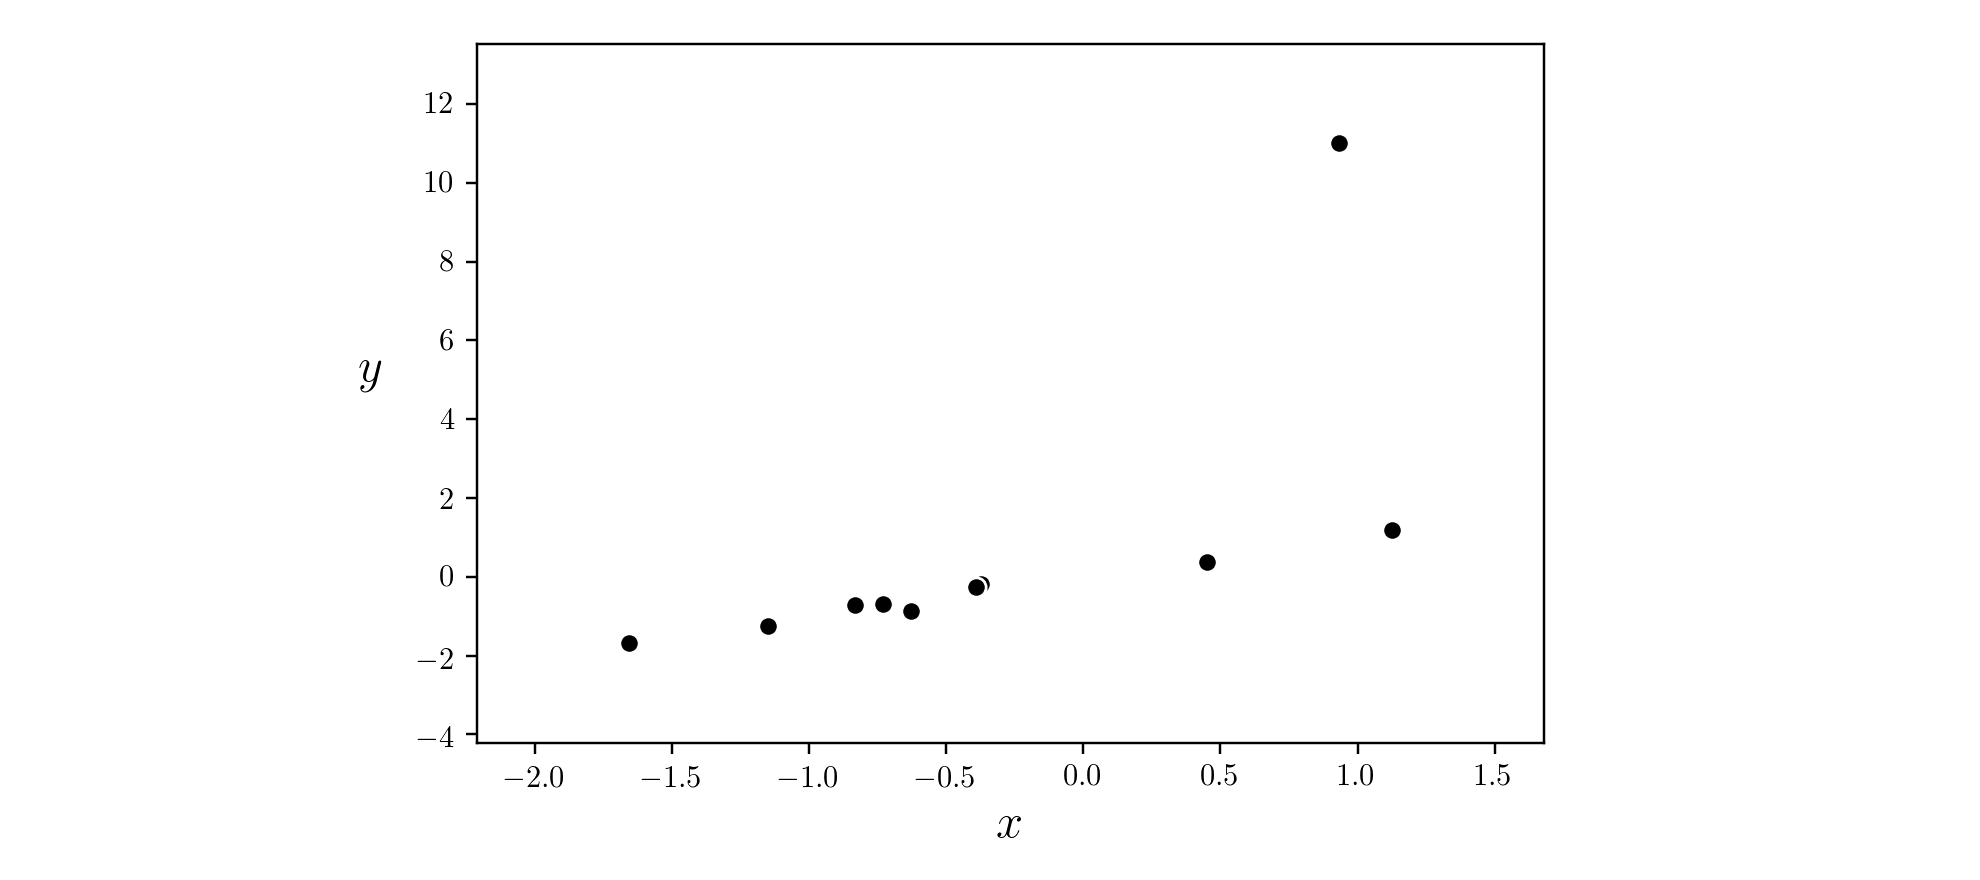

In [2]:
# load in dataset
datapath = '../../mlrefined_datasets/superlearn_datasets/regression_outliers.csv'
data = np.loadtxt(datapath,delimiter = ',')
x = data[:,:-1].T
y = data[:,-1:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

We now tune the parameters of a linear regressor to this dataset by minimizing the Least squares cost via gradient descent.  $20$ steps are indeed sufficient in this case (as we can verify by visually examining the cost function history plot).

In [3]:
# compute linear combination of input point
def model(x,w):
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(x)[1]))
    x = np.vstack((o,x))
    
    # compute linear combination and return
    a = np.dot(x.T,w)
    return a

# an implementation of the least squares cost function for linear regression
def least_squares(w):
    cost = np.sum((model(x,w) - y)**2)
    return cost/float(len(y))

# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; w = np.array([1.0,1.0])[:,np.newaxis]; max_its = 20; alpha_choice = 10**(-1);
weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)

Now we plot the linear model associated with those weights providing the smallest cost function value during the run below.  This fit (shown in black) does not fit the majority of the data points well, bending upward clearly to with the aim of minimizing the large squared error on the singleton outlier point.

<IPython.core.display.Javascript object>


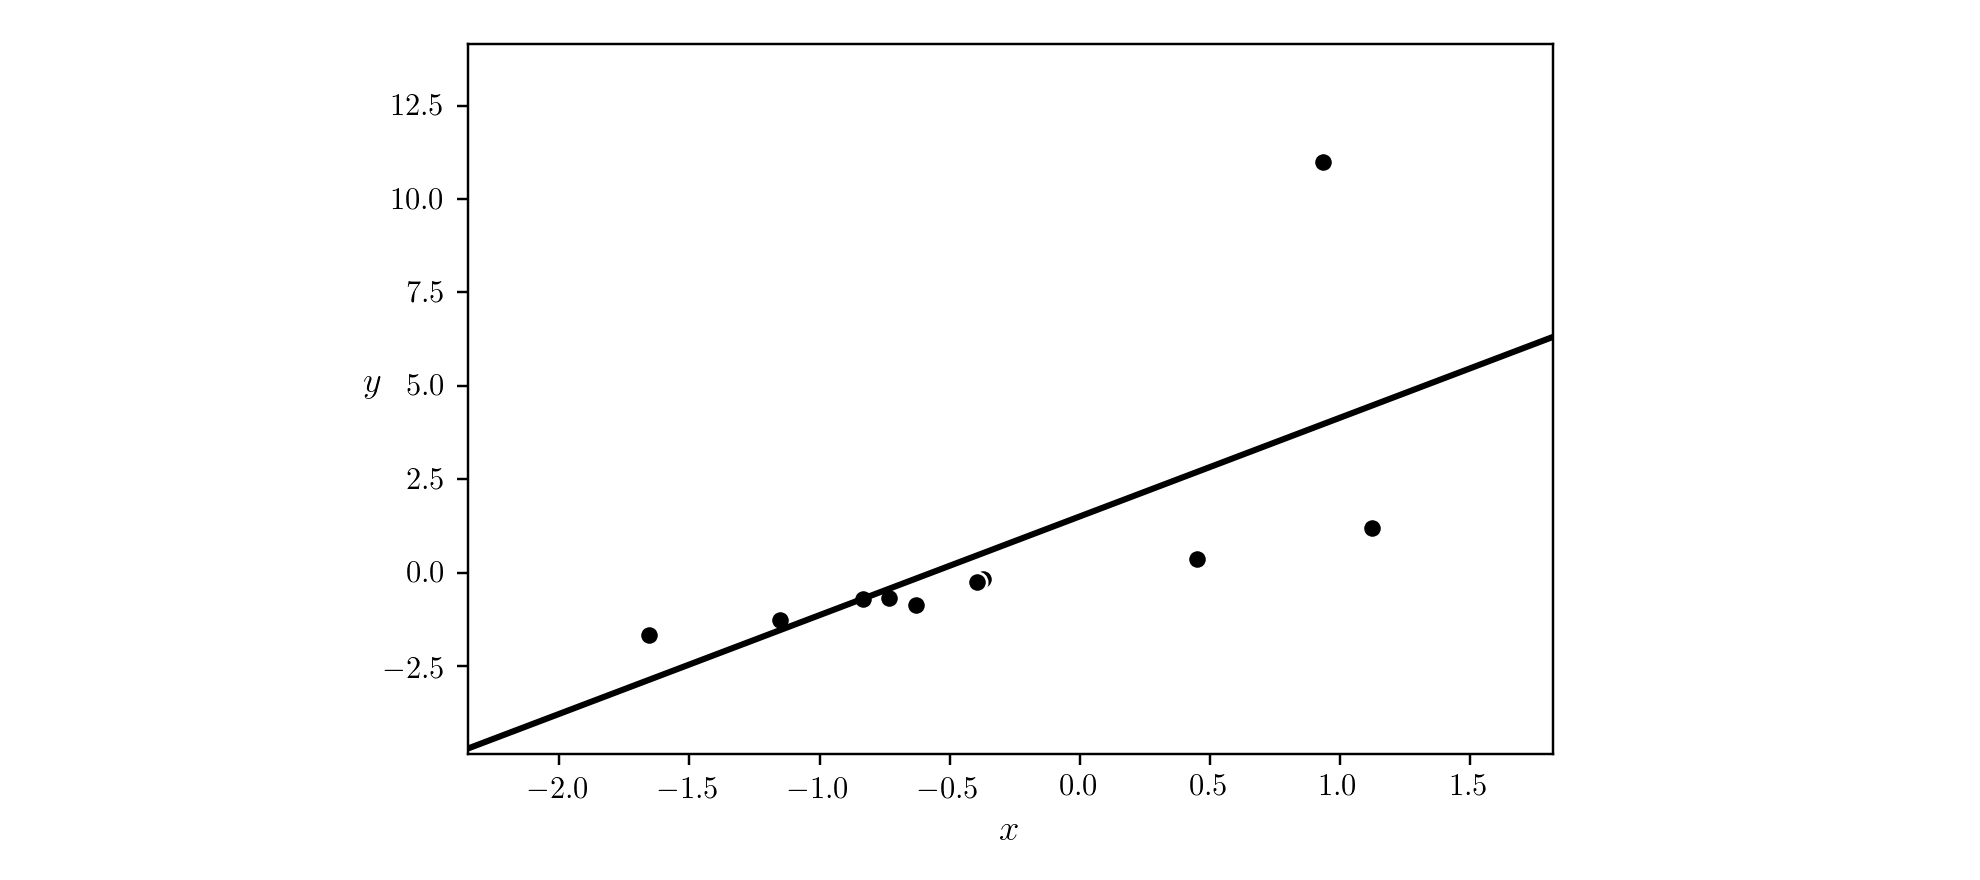

In [4]:
# grab best weights from minimization of Least Squares cost
ind = np.argmin(cost_history_1)
least_weights = weight_history_1[ind]
demo.plot_fit(plotting_weights = [least_weights])

---

## 8.3.2  Replacing squared error with absolute error

How can we make our linear regression framework more robust to outliers?  If we return the original derivation of the Least Squares cost function in subsection 8.1.2, our aim in learning a linear regressor is to learn a set of ideal weights so that 

\begin{equation}
\mathbf{x}_{p}^T\mathbf{w} \approx y_{p} \,\,\,\,\,\,\,\, p=1,...,P
\end{equation}

for a dataset of $P$ points $\left \{ \mathbf{x}_p,\,y_p \right \}_{p=1}^P$.  To learn these ideal weights the first step we took there was to square the difference between both sides of each desired approximation above as 

\begin{equation}
\left(\mathbf{x}_{p}^{T}\mathbf{w} - y_{p}^{\,}\right)^2  \,\,\,\,\,\,\,\, p=1,...,P.
\end{equation}

Each of these measures the *squared error* between model $w_0+\mathbf{x}_{p}^{T}\mathbf{w}$ and $y_{p}^{\,}$.  Taking the average of these $P$ squared error terms gave us the Least Squares cost function.  

 As an alternative to forming the *squared* error of each desired approximation, we can instead measure the *absolute error* for each desired approximation
 
 \begin{equation}
\left \vert \mathbf{x}_{p}^{T}\mathbf{w}^{\,} - y_{p}^{\,}\right \vert  \,\,\,\,\,\,\,\, p=1,...,P.
\end{equation}

By using absolute error instead of the squared variety we do not exaggerate the importance of large errors greater than $1$ (since, of course, we do not square them).  If we form the average of these absolute error measurements we have the cousin of Least Squares, the so-called *Least Absolute Deviations* cost function 

\begin{equation}
\,g\left(\mathbf{w}\right)=\frac{1}{P}\sum_{p=1}^{P}\left\vert  \mathbf{x}_{p}^{T}\mathbf{w}^{\,}-y_{p}^{\,}\right\vert.
\end{equation}

The only price we pay in employing the absolute error instead of the squared error is a technical one: we are more limited in which optimization schemes we can apply to minimize the Least Absolute Deviations cost.  While this cost function is also always convex regardless of the input dataset, can only use zero / first order methods  to properly minimize it no second order methods (because the second derivative of this cost function is zero almost everywhere, as can easily be shown). 

Nonetheless, being limited to using local optimization methods like gradient descent is no severe condemnation - gradient descent is the most widely used optimization algorithm in machine learning / deep learning!

#### <span style="color:#a50e3e;">Example 2: </span>  Least absolute deviations versus Least Squares

With the sort of implementation philosophy described in Section 8.1.3 - where we break down a cost function into its basic components for modular implementation - we can think equivalently about the cost in equation (4) as

\begin{equation}
\,g\left(\mathbf{w}\right)=\frac{1}{P}\sum_{p=1}^{P}\left\vert\text{model}\left( \mathbf{x}_p,\mathbf{w}\right) -y_{p}^{\,}\right\vert.
\end{equation}

where we have denoted our linear `model` of the input and weights as

\begin{equation}
\text{model}\left(\mathbf{x}_p,\mathbf{w}\right) = \mathbf{x}^T_p \mathbf{w}.
\end{equation}

In implementing the cost in `Python` we can employ the ``model`` function we used with our Least Squares implementation shown in e.g., Example 1, since this is how we implement the linear combination of our input and weights.  All we then need to do is slightly alter the cost function itself to get our desired implementation, as shown below.

In [5]:
# a compact least absolute deviations cost function
def least_absolute_deviations(w):
    cost = np.sum(np.abs(model(x,w) - y))
    return cost/float(len(y))

Below we plot the surface / contour plot of this cost function using the previously shown dataset - indeed it is convex.

<IPython.core.display.Javascript object>


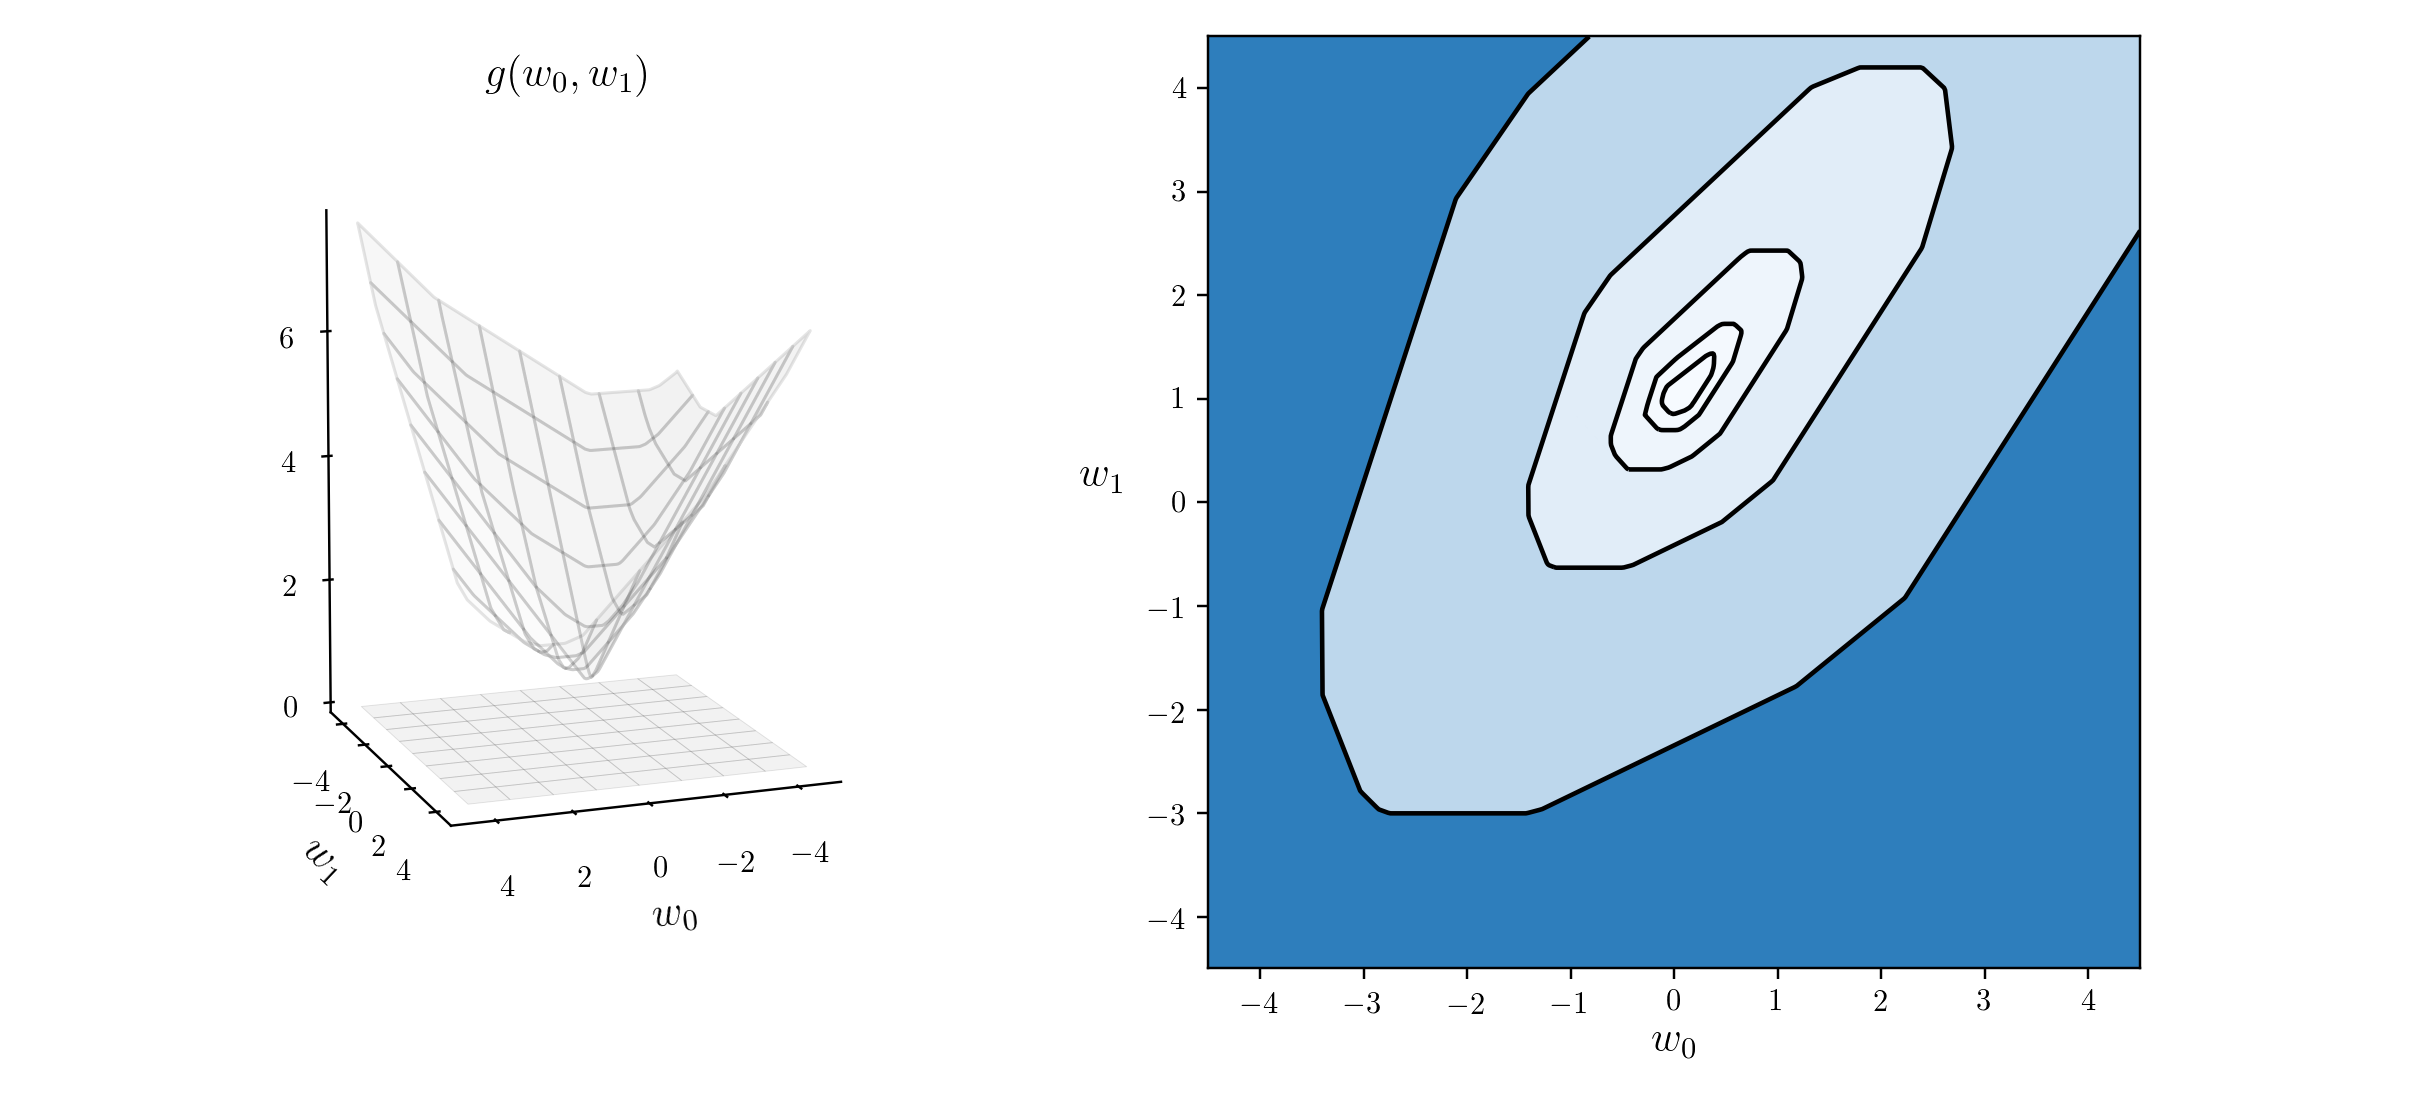

In [6]:
# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_surface_contour_plot(least_absolute_deviations,[],view = [10,70],xmin = -4.5, xmax = 4.5, ymin = -4.5, ymax = 4.5,num_contours = 5)

Below we run gradient descent for $100$ iterations, using the same choice of steplength parameter as used in the previous example.

In [7]:
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_absolute_deviations; w = np.array([1.0,1.0])[:,np.newaxis]; max_its = 20; alpha_choice = 10**(-1);
weight_history_2,cost_history_2 = optimizers.gradient_descent(g,alpha_choice,max_its,w)

With gradient descent complete we plot and visually compare the cost function histories for the run made on the Least Squares cost (shown in black) in the previous example, and our recent run above (shown in magenta).  Examining the cost function histories below, we can see that the cost function value of the Least Absolute Deviations cost is considerably lower than that of Least Squares.  This alone provides evidence that the former will provide a considerably better fit than Least Squares.

<IPython.core.display.Javascript object>


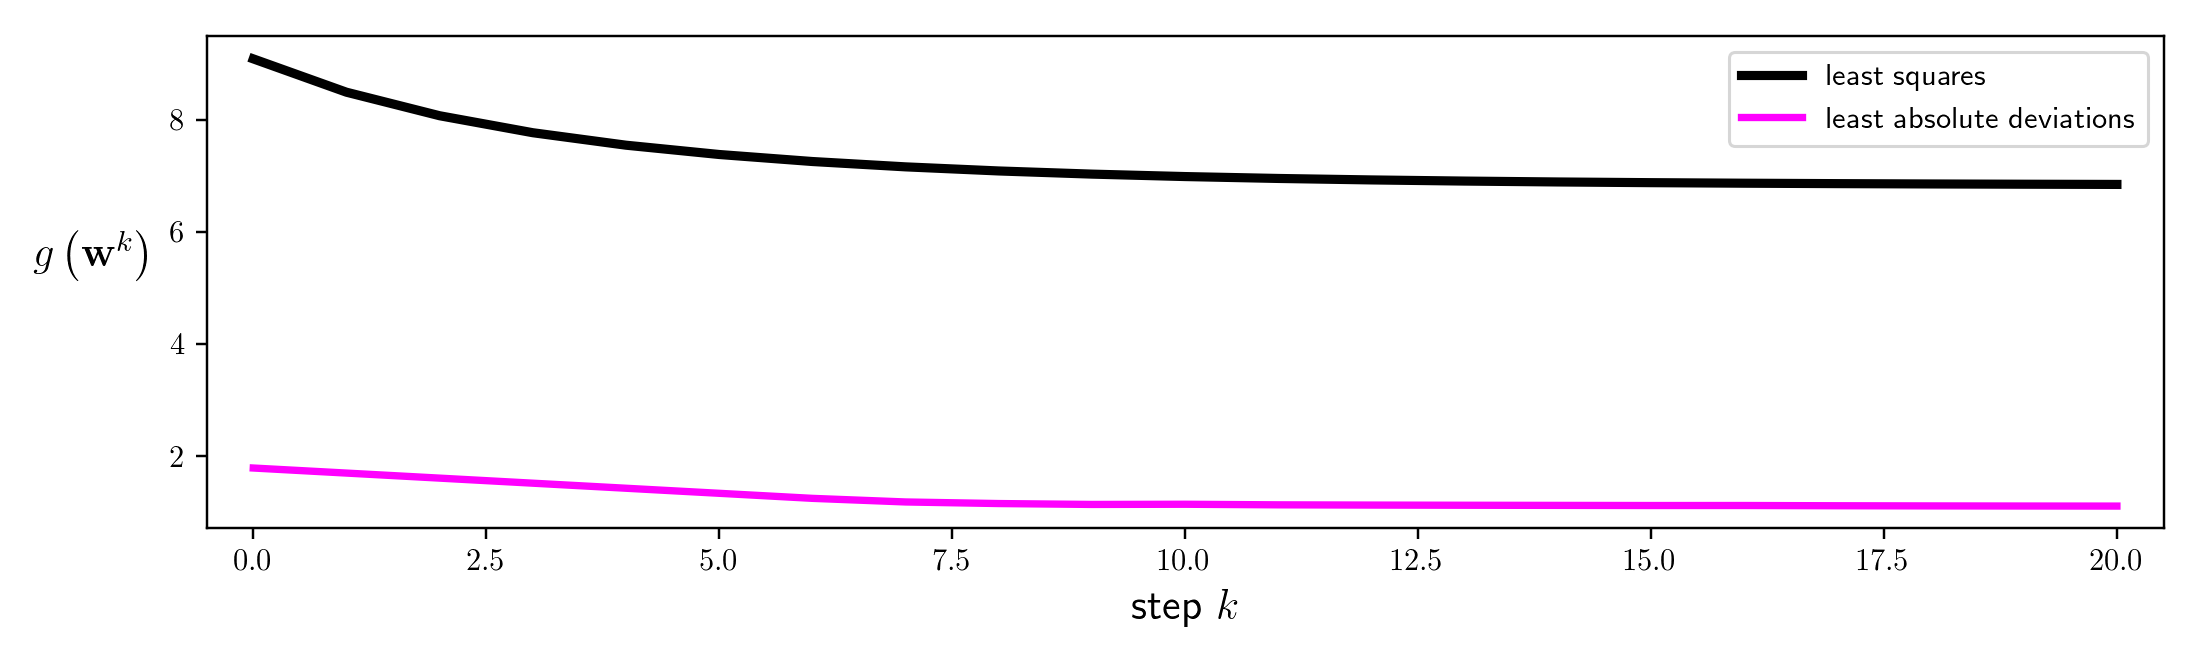

In [8]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = False,labels = ['least squares','least absolute deviations'])

Now we plot and compare the best fit found via gradient descent for both cost functions on the dataset.  The Least Squares fit is shown in black, while the Least Absolute Deviation fit is shown in magenta.  The latter fits considerably better, since it does not exaggerate the large error produced by the single outlier.

<IPython.core.display.Javascript object>


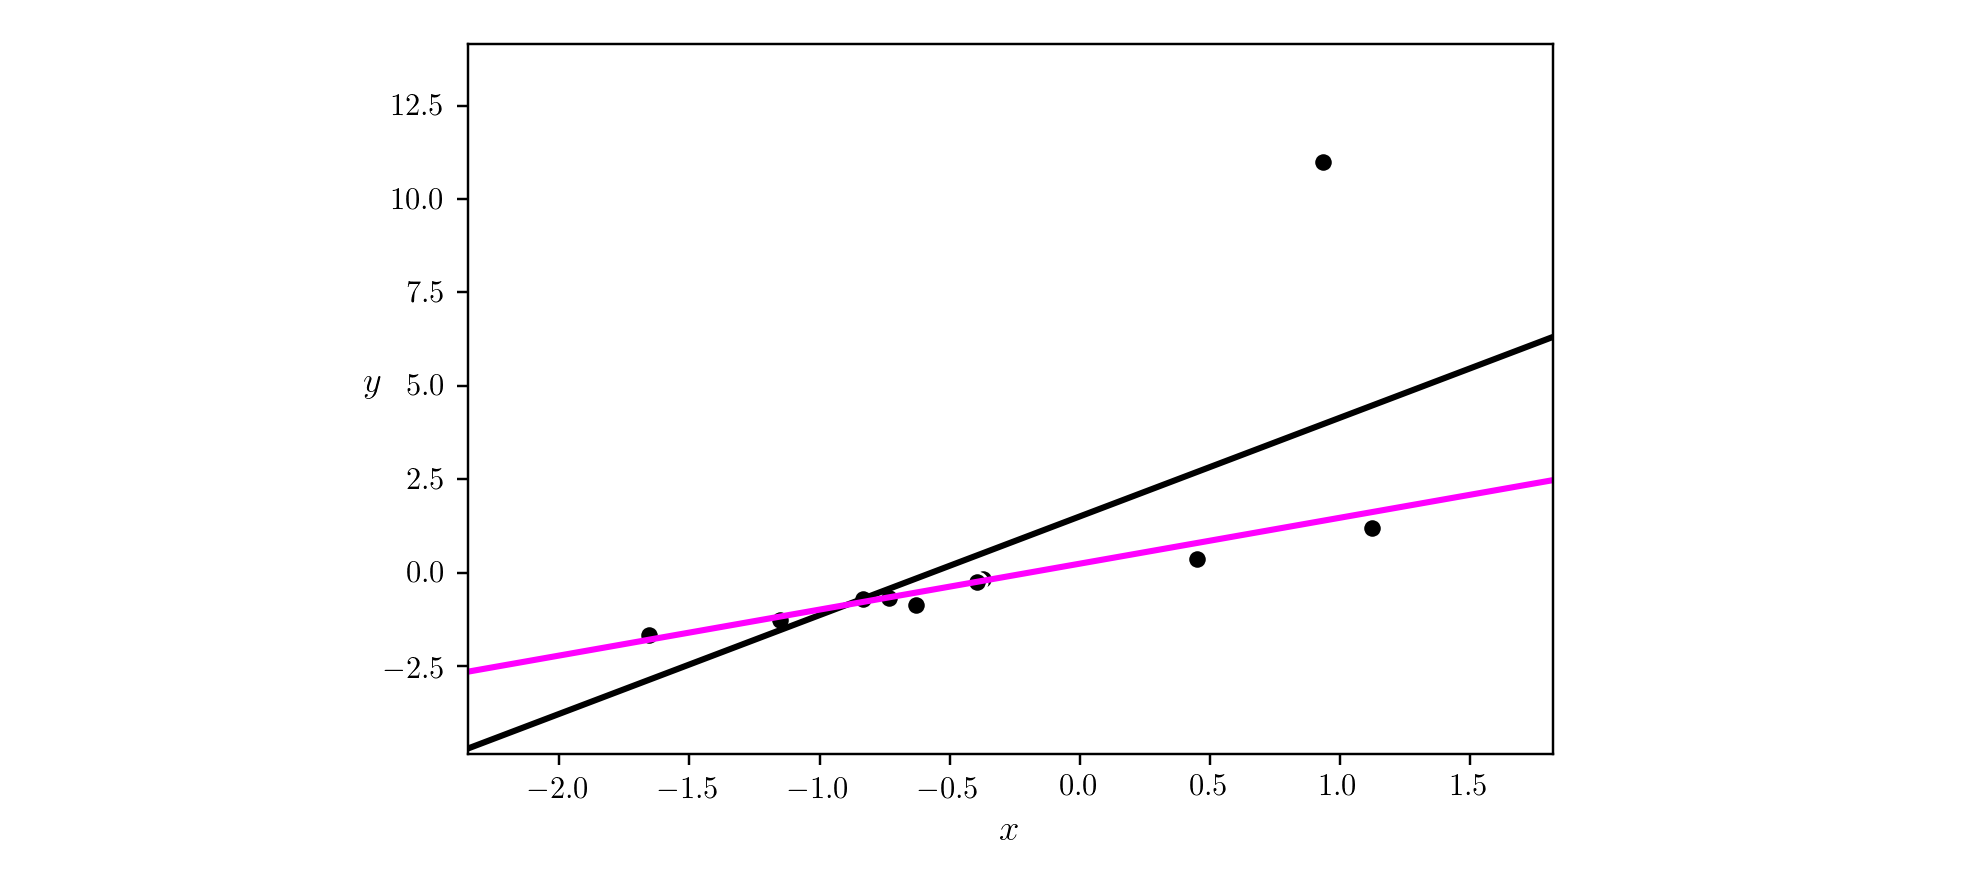

In [9]:
# find best set of weights from gradient descent run on Least Absolute Deviations cost 
ind = np.argmin(cost_history_2)
absolute_weights = weight_history_2[ind]
demo.plot_fit(plotting_weights = [least_weights,absolute_weights])